:::{admonition} Download
:class: important

This notebook can be downloaded as **{nb-download}`introduction.ipynb`**. See the button at the top right to download as markdown or pdf.

:::

# Introduction

The goal of this notebook is to give a brief introduction to plenoptic: we'll use two of our synthesis methods with a handful of models, and try to step through the kind of scientific reasoning that plenoptic's synthesis methods facilitate. If you're interested in learning more about this, ask me questions or [check out our documentation](https://plenoptic.readthedocs.io)!

:::{admonition} Questions
:class: important

Throughout this notebook, there will be several questions that look like this. You are encouraged to stop and think about the question, to try and answer it yourself (perhaps looking at the hints that follow) before moving on and reading the answer below it.

:::

As described in my presentation, the goal of plenoptic is to provide methods for model-based synthesis of stimuli, facilitating better understanding of how the models make sense of those stimuli: what information is discarded, what is important, etc. These methods have mostly been used on images, which we'll use here, but they also work well on sounds as well.

In order to use plenoptic, we need some models! Normally, this will depend on your research problem: you'll use models that you've developed or fit in previous experiments, or that get used in the literature. For example, if you're studying V1, you could use an energy model of complex cells; if you're studying object recognition, you might use a deep network-based model.

<div class='render-both'>
<img src="_static/models.png">

For the purposes of this notebook, we'll use some very simple convolutional models that are inspired by the processing done in the lateral geniculate nucleus (LGN) of the visual system[^models]. We're going to build up in complexity, starting with the Gaussian model at the top and gradually adding features[^notallmodels]. We'll describe the components of these models in more detail as we get to them, but briefly:

[^models]: Most of these models were originally published in Berardino, A., Laparra, V., J Ball\'e, & Simoncelli, E. P. (2017). Eigen-distortions of hierarchical representations. In Adv. Neural Information Processing Systems (NIPS*17), from which the figure is modified.

[^notallmodels]: Note that the Berardino et. al, 2017 paper includes more models than described here. We're not examining all of them for time's sake, but you can check out the rest of the models described in the Berardino paper, they're all included in plenoptic under the [plenoptic.simulate.FrontEnd](https://plenoptic.readthedocs.io/en/latest/api/plenoptic.simulate.models.html#module-plenoptic.simulate.models.frontend) module!

- `Gaussian`: the model just convolves a Gaussian with an image, so that the model's representation is simply a blurry version of the image.
- `CenterSurround`: the model convolves a difference-of-Gaussian filter with the image, so that model's representation is bandpass, caring mainly about frequencies that are neither too high or too low.
- `LuminanceGainControl`: the model rectifies and normalizes the linear component of the response using a local measure of luminance, so that the response is invariant to local changes in luminance.
</div>

## Plenoptic basics

Let's get started! First, we'll import packages and set some configuration options:

In [1]:
import plenoptic as po
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72
plt.rcParams['animation.html'] = 'html5'
# use single-threaded ffmpeg for animation writer
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_args'] = ['-threads', '1']

%matplotlib inline

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if DEVICE.type == 'cuda':
    print("Running on GPU!")
else:
    print("Running on CPU!")
# for reprodicibility
po.tools.set_seed(1)

Running on GPU!


In addition to our models, all `plenoptic` methods require a "reference" or "target" image --- for Metamer synthesis, for example, this is the image whose representation we will match. Let's load in an image of Einstein to serve as our reference here:

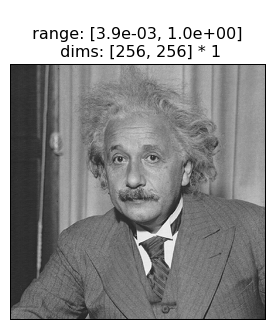

In [2]:
img = po.data.einstein().to(DEVICE)
fig = po.imshow(img)

Models can be really simple, as this demonstrates. It needs to inherit `torch.nn.Module`[^module] and just needs two methods: `__init__` (so it's an object) and `forward` (so it can take an image). 

[^module]: Technically, this isn't necessary, but it will make your life easier. See [our documentation](https://plenoptic.readthedocs.io/en/latest/models.html) for details.

To start, we'll create the `Gaussian` model described above:

<div class='render-strip'>
Set up the Guassian model. Models in plenoptic must:
- Inherit `torch.nn.Module`.
- Accept 4d tensors as input and return 3d or 4d tensors as output.
- Have `forward` and `__init__` methods.
- Have all gradients removed.
</div>

In [3]:
# this is a convenience function for creating a simple Gaussian kernel
from plenoptic.simulate.canonical_computations.filters import circular_gaussian2d

# Simple Gaussian convolutional model
class Gaussian(torch.nn.Module):
    # in __init__, we create the object, initializing the convolutional weights and nonlinearity
    def __init__(self, kernel_size, std_dev=3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = torch.nn.Conv2d(1, 1, kernel_size=kernel_size, padding=(0, 0), bias=False)
        self.conv.weight.data[0, 0] = circular_gaussian2d(kernel_size, float(std_dev))
        
    # the forward pass of the model defines how to get from an image to the representation
    def forward(self, x):
        x = po.tools.conv.same_padding(x, self.kernel_size, pad_mode='circular')
        return self.conv(x)

# we pick this particular number to match the models found in the Berardino paper
model = Gaussian((31, 31)).to(DEVICE)
rep = model(img)

To work with our synthesis methods, a model must accept a 4d tensor as input and return a 3d or 4d tensor as output. 4d inputs are commonly used for pytorch models, and the dimensions are batch (often, multiple images), channel (often, RGB or outputs of different convolutional filters), height, and width. The model should then either return a 1d vector or a 2d image *per batch and channel*, for a total of 3 (`batch, channel, vector`) or 4 (`batch, channel, height, width`) dimensions. If your model operates across channels or batches, that's no problem; for example if the model transforms RGB to grayscale, your input would have 3 channels and your output would have 1.

We can see that our `Gaussian` model satisfies this constraint:

In [4]:
print(img.shape)
print(rep.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


There's one final step before this model is ready for synthesis. Most `pytorch` models will have learnable parameters, such as the weight on the convolution filter we created above, because the focus is generally on training the model to best perform some task. In `plenoptic`, models are *fixed* because we take the opposite approach: generating some new stimulus to better a understand a given model. Thus, all synthesis methods will raise a `ValueError` if given a model with any learnable parameters. We provide a helper function to remove these gradients. Similarly, we probably also want to call `.eval()` on the model, in case it has training-mode specific behavior: that's not the case here (I'm just being pedantic), but it might be the case, depending on your model, and [pytorch's documentation](https://pytorch.org/docs/stable/notes/autograd.html#evaluation-mode-nn-module-eval) recommends calling `.eval()` just in case.

In [5]:
po.tools.remove_grad(model)
model.eval()

Gaussian(
  (conv): Conv2d(1, 1, kernel_size=(31, 31), stride=(1, 1), bias=False)
)

The following shows the image and the model output. We can see that output is a blurred version of the input, as we would expect from a low-pass model.

<div class='render-strip'>
- The Gaussian model output is a blurred version of the input.
- This is because the model is preserving the low frequencies,  discarding the high frequencies (i.e., it's a lowpass filter).
- Thus, this model is completely insensitive to high frequencies -- information there is invisible to the model.
</div>

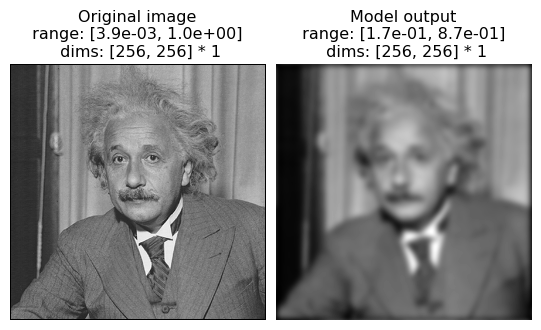

In [6]:
fig = po.imshow(torch.cat([img, rep]), title=['Original image', 'Model output'])

Before moving forward, let's think about this model for a moment. It's a simple Gaussian convolution which throws out high-frequency information, as we can see in the representation above. Metamers provide a tool for exploring a model's insensitivities, so any metamers we synthesize should capitalize on this: they should differ from the original image in the high frequencies.


## Examining model invariances with metamers

Okay, now we're ready to start with metamer synthesis. To initialize, we only need the model and the image. Optimization-related arguments are set when calling `.synthesize()` and, in general, you'll probably need to play with these options to find a good solution. It's also probably a good idea, while getting started, to set `store_progress` to `True` (to store every iteration) or some `int` (to store every `int` iterations) so you can examine synthesis progress.

<div class='render-strip'>
- Initialize the `Metamer` object and synthesize a model metamer.
- View the synthesis process.
</div>

In [7]:
metamer = po.synthesize.Metamer(img, model)

matched_im = metamer.synthesize(store_progress=True, max_iter=20)
# if we call synthesize again, we resume where we left off
matched_im = metamer.synthesize(store_progress=True, max_iter=150)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

/home/agent/workspace/neurorse_plenoptic-vss-2025_main/lib/python3.11/site-packages/plenoptic/synthesize/metamer.py:275: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


After synthesis runs, we can examine the loss over time. There's a convenience function for this, but you could also call `plt.semilogy(metamer.losses)` to create it yourself.

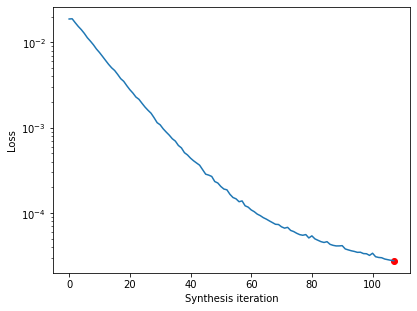

In [8]:
po.synthesize.metamer.plot_loss(metamer);

The loss decreases steadily and has reached a very low value. In fact, based on our convergence criterion (one of the optional arguments), it looks as though we've converged (we could change this argument to continue synthesis).

We can also view a movie of our synthesis progress:

<div class='render-strip'>

:::{important} 
This next cell will take a while to run --- making animations in matplotlib is a bit of a slow process.
:::

</div>

In [9]:
po.synthesize.metamer.animate(metamer, included_plots=['display_metamer', 'plot_loss'], figsize=(12, 5))

In the above, we see that we start with white noise, and gradually update the pixel values so as to make the model's representation of this image the same as that of our target Einstein image.

We can then look at the reference and metamer images, as well as the model's outputs on the two images:

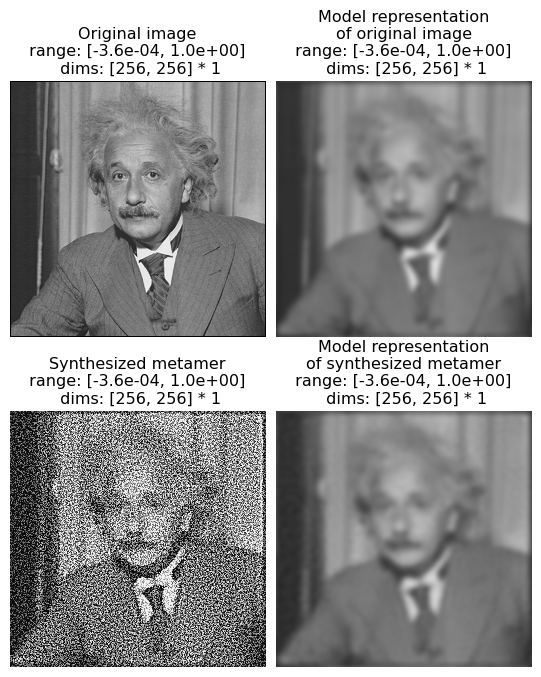

In [10]:
fig = po.imshow([img, rep, metamer.metamer, model(metamer.metamer)], 
                col_wrap=2, vrange='auto1',
                title=['Original image', 'Model representation\nof original image',
                       'Synthesized metamer', 'Model representation\nof synthesized metamer']);

We can see that, even though the target and synthesized images look very different, the two model outputs look basically identical (which matches the exceedingly low loss value we see above). (The left column shows the images and the right column the model outputs; top row shows the original image and bottom the synthesized metamer.)

:::{admonition} Question
:class: important

Why does the model metamer look "staticky"?
:::

:::{admonition} Hint
:class: hint dropdown

Model metamers help us examine the model's nullspace, its invariances. A Gaussian is a lowpass filter, so what information is it insensitive to?
:::

It may seem strange that the synthesized image looks like it has high-frequency noise in it --- a Gaussian is a low-pass filter, so why isn't the model metamer just a blurred version of the original image? Indeed, such a blurred image would be a model metamer, but it's only one of many. Remember what we mentioned earlier: Gaussians are insensitive to high-frequency information, which not only means that their response doesn't change when you remove that information, but that you can put any amount of high frequency information into an image without affecting the model's output. Put another way, you can randomize the contents of the model's null space without affecting its response, and the goal of metamer synthesis is to generate different images that do just that.

We can see the model's insensitivity to high frequencies more dramatically by initializing our metamer synthesis with a different image. By default, we initialize with a patch of white noise, but we can initialize with any image of the same size. Let's try with two different images, a sample of pink noise and a picture of Marie Curie.

<div class='render-strip'>
- Synthesize more model metamers, from different starting points.
</div>

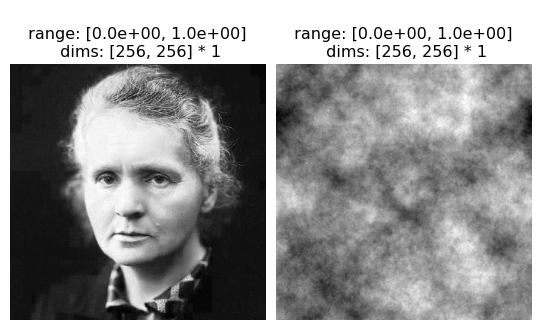

In [11]:
curie = po.data.curie().to(DEVICE)
# pyrtools, imported as pt, has a convenience function for generating samples of white noise, but then we still 
# need to do some annoying things to get it ready for plenoptic
pink = torch.from_numpy(pt.synthetic_images.pink_noise((256, 256))).unsqueeze(0).unsqueeze(0)
pink = po.tools.rescale(pink).to(torch.float32).to(DEVICE)
po.imshow([curie, pink]);

We run synthesis in the same way as before, just setting the optional argument `initial_image`:

In [12]:
metamer_curie = po.synthesize.Metamer(img, model)
metamer_curie.setup(initial_image=curie)
metamer_pink = po.synthesize.Metamer(img, model) 
metamer_pink.setup(initial_image=pink)

# we increase the length of time we run synthesis and decrease the
# stop_criterion, which determines when we think loss has converged
# for stopping synthesis early.
metamer_curie.synthesize(max_iter=500,  stop_criterion=1e-7)
metamer_pink.synthesize(max_iter=500,  stop_criterion=1e-7)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Let's double-check that our synthesis looks like it's reached a good solution by checking the loss curve:

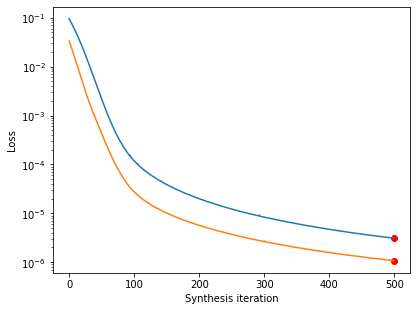

In [13]:
po.synthesize.metamer.plot_loss(metamer_curie)
po.synthesize.metamer.plot_loss(metamer_pink);

<div class='render-strip'>
In the following plot:
- the first row shows our target Einstein image and its model representation, as we saw before.
- the new three rows show our model metamers resulting from three different starting points.
- in each, the first column shows the starting point of our metamer synthesis, the middle shows the resulting model metamer, and the third shows the model representation.

We can see that the model representation is the same for all four images, but the images themselves look very different. Because the model is completely invariant to high frequencies, the high frequencies present in the initial image are not affected by the synthesis procedure and thus are still present in the model metamer.
</div>

Good, now let's examine our synthesized metamer and the model output for all our initial images:

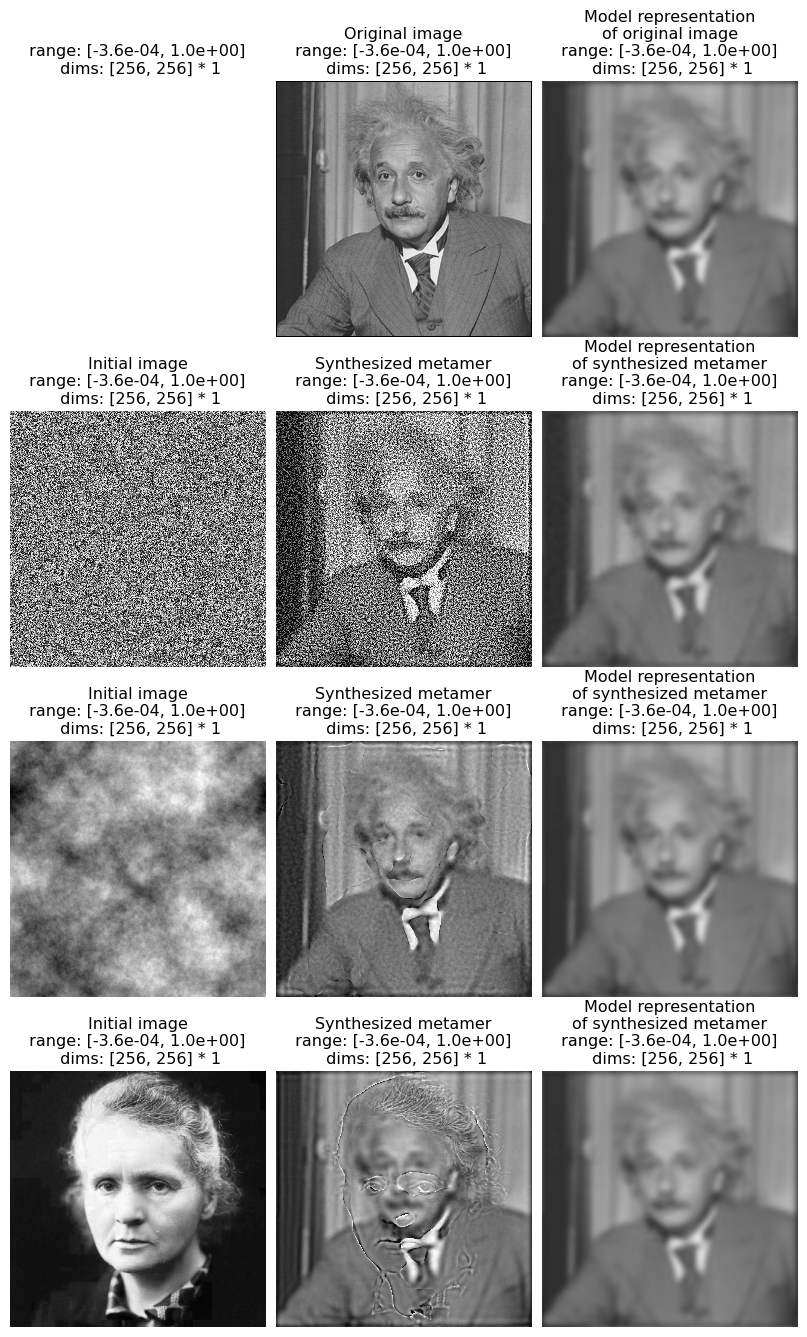

In [14]:
fig = po.imshow([torch.ones_like(img), img, rep,
                 metamer.saved_metamer[0], metamer.metamer, model(metamer.metamer),
                 pink, metamer_pink.metamer, model(metamer_pink.metamer),
                 curie, metamer_curie.metamer, model(metamer_curie.metamer)],
                col_wrap=3, vrange='auto1',
                title=['', 'Original image', 'Model representation\nof original image']+
                      3*['Initial image', 'Synthesized metamer', 'Model representation\nof synthesized metamer']);

We see that the new synthesized metamers looks quite different from both the original and from our previous metamer, while the model outputs of all the images look very similar. In the third row, the synthesized model metamer looks like a blurry picture of Einstein with a high-frequency "shadow" of Curie added on top. Again, this is because the Gaussian model is insensitive to high frequencies, and thus a model metamer can include any high frequency information. In the final row, we can see that our model metamer looks like a blurry picture of Einstein --- because pink noise has very little information in the high frequencies (and the information that is present is incoherent), our resulting metamer appears to have little information present.

## Examining model sensitivies to eigendistortions

By generating model metamers, we've gained a better understanding of the information our model is invariant to, but what if we want a better understanding of what our model is sensitive to? We can use `Eigendistortion` for that.

Like `Metamer`, `Eigendistortion` accepts an image and a model as its inputs. By default, it synthesizes the top and bottom eigendistortion, that is, the changes to the input image that the model finds most and least noticeable.

<div class='render-strip'>
- While metamers allow us to examine model invariances, eigendistortions allow us to also examine model sensitivities.
- Eigendistortions are distortions that the model thinks are the most and least noticeable.
- They can be visualized on their own or on top of the reference image.
</div>

In [15]:
eig = po.synthesize.Eigendistortion(img, model)
eig.synthesize();

Top k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Top k=1 eigendists computed | Stop criterion 1.00E-07 reached.


Bottom k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Let's examine those distortions:

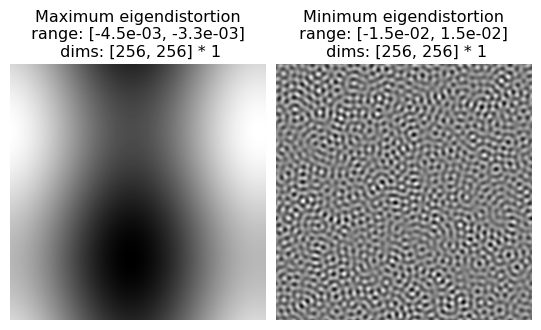

In [16]:
po.imshow(eig.eigendistortions, title=['Maximum eigendistortion', 
                                       'Minimum eigendistortion']);

We can see they make sense: the most noticeable distortion is a very low-frequency modification to the image, with a period of about half the image. The least noticeable, on the other hand, is very high-frequency, which matches our understanding from the metamer example above. This is clearer if we add them to our Einstein in order to view them together:

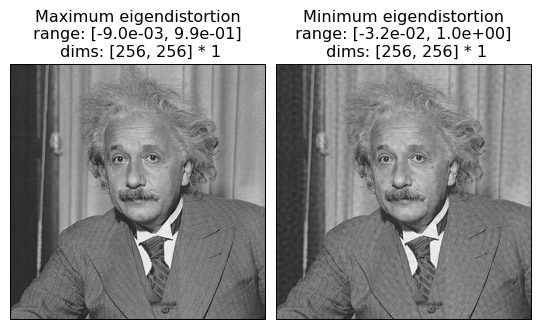

In [17]:
po.imshow(img + 3*eig.eigendistortions, title=['Maximum eigendistortion', 
                                               'Minimum eigendistortion']);

## A more complex model

Now we feel pretty confident that we understand how a simple Gaussian works, what happens when we make the model more complicated? Let's try changing the filter from a simple lowpass to a bandpass filter, which have sensitivities more similar to those of neurons in the early human visual system. To do this, we'll use plenoptic's built-in `CenterSurround` object:

<div class='render-strip'>
- The `CenterSurround` model has bandpass sensitivity, as opposed to the `Gaussian`'s lowpass.
- Thus, it is still insensitive to the highest frequencies, but it is less sensitive to the low frequencies the Gaussian prefers, with its peak sensitivity lying in a middling range.
</div>

In [18]:
# These values come from Berardino et al., 2017.
center_surround = po.simulate.CenterSurround((31, 31), center_std=1.962, surround_std=4.235,
                                             pad_mode='circular').to(DEVICE)
po.tools.remove_grad(center_surround)
center_surround.eval()
center_surround(img).shape

torch.Size([1, 1, 256, 256])

Before synthesizing our metamers, let's look at the model representation:

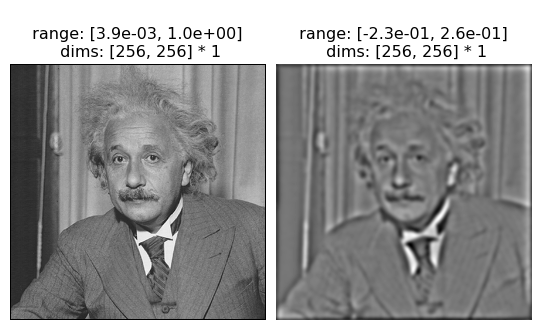

In [19]:
po.imshow([img, center_surround(img)]);

While the Gaussian model above was lowpass, throwing away high frequencies and preserving the low, the Center-Surround model is bandpass. It is thus most sensitive to frequencies found in the middle, and less sensitive to both high and low frequencies[^bandpass]. We can see that in the figure above because the image looks "sharper" than the Gaussian representation (showing that it contains more high frequencies) while also being an overall "mean gray" (showing that it is discarding the low frequencies that account for making portions of the image dark or light).

We can make use of multi-batch processing in order to synthesize the metamers with different start points, as above, using a single `Metamer` object:

<div class='render-strip'>
- We can synthesize all three model metamers at once by taking advantage of multi-batch processing.
</div>

In [20]:
white_noise =  po.tools.rescale(torch.rand_like(img), a=0, b=1).to(DEVICE)
init_img = torch.cat([white_noise, pink, curie], dim=0)
# metamer does a 1-to-1 matching between initial and target images,
# so we need to repeat the target image on the batch dimension
cs_metamer = po.synthesize.Metamer(img.repeat(3, 1, 1, 1), center_surround)
cs_metamer.setup(initial_image=init_img)
cs_metamer.synthesize(1000, stop_criterion=1e-7)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/agent/workspace/neurorse_plenoptic-vss-2025_main/lib/python3.11/site-packages/plenoptic/synthesize/metamer.py:275: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


Now let's visualize our outputs (the code to create this plot is slightly annoying, so we're hiding it):

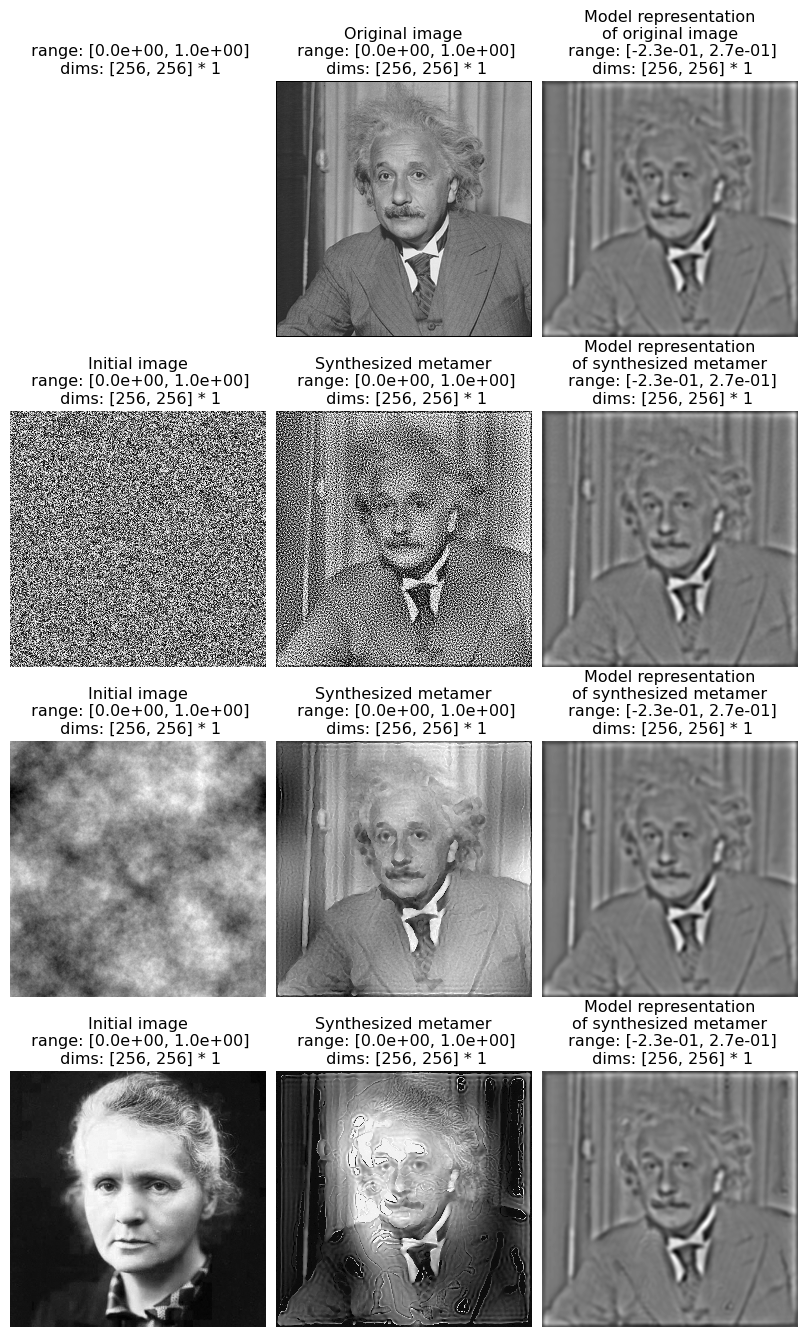

In [21]:
# this requires a little reorganization of the tensors:
to_plot = [torch.cat([torch.ones_like(img), img, center_surround(img)])]
for i, j in zip(init_img, cs_metamer.metamer):
    to_plot.append(torch.stack([i, j, center_surround(j)]))
to_plot = torch.cat(to_plot)
fig = po.imshow(to_plot, col_wrap=3, 
                title=['', 'Original image', 'Model representation\nof original image']+
                       3*['Initial image', 'Synthesized metamer', 'Model representation\nof synthesized metamer']);
# change the color scale of the images so that the first two columns go from 0 to 1 
# and the last one is consistent
for ax in fig.axes:
    if 'representation' in ax.get_title():
        clim = (to_plot[2::3].min(), to_plot[2::3].max())
    else:
        clim = (0, 1)
    ax.images[0].set_clim(*clim)
    title = ax.get_title().split('\n')
    title[-2] = f" range: [{clim[0]:.01e}, {clim[1]:.01e}]" 
    ax.set_title('\n'.join(title))

The layout of the plots here is the same as before: the top row shows our target image and its model representation, while the next rows each show a separate model metamer in the middle column, with their different initial points in the left column and their model representations on the right. We can see that the model representation in each row looks the same, while the middle columns look very different. 

:::{admonition} Question
:class: important

How do these model metamers differ from the Gaussian ones? How does that relate to what we know about the model's sensitivities and invariances?
:::

While these model metamers look reasonably similar to the metamers of the `Gaussian` model, a somewhat blurry Einstein with some additional info riding on top, if we look carefully, we can notice some important differences:

- in the white noise metamer, the mean values appear to be different: the dark side of the room on the left side of the picture, as well as his suit, appear to be lighter.
- whereas the `Gaussian` pink noise metamer just appeared to be blurry, the `CenterSurround` one has dark and light patches that roughly match up with the original noise seed.
- the differences are most striking in the Curie metamer, as the initial image was completely black except for Marie Curie's face, which is fairly white. The resulting metamer, therefore, is much darker than the target everywhere except the center of the image, which is much brighter.

In all of these, the differences are the result of the fact that our model now consists of a [difference-of-Gaussians filter](https://en.wikipedia.org/wiki/Difference_of_Gaussians) than a Gaussian. As described earlier, this results in a model with *bandpass* selectivity, rather than *lowpass*. Thus, the `CenterSurround` doesn't care about low frequency information like the local mean pixel value and we can change it without affecting its output[^bandpass].

[^bandpass]: The `CenterSurround` model does retain some sensitivity to lower frequencies, but it's much less sensitive to them than the `Gaussian` model is. The `CenterSurround` retains some low frequency selectivity because its two Gaussians are not perfectly balanced; to play around with their balance, try changing the `amplitude_ratio` argument.

The change from a lowpass to a bandpass model also changes the model's most sensitive frequencies, though we can't easily tell that using model metamers. We can, however, using eigendistortions!

<div class='render-strip'>
- By examining the eigendistortions, we can see more clearly that the model's preferred frequency has shifted higher, while the minimal eigendistortion still looks fairly similar.
</div>

Top k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Top k=1 eigendists computed | Stop criterion 1.00E-07 reached.


Bottom k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

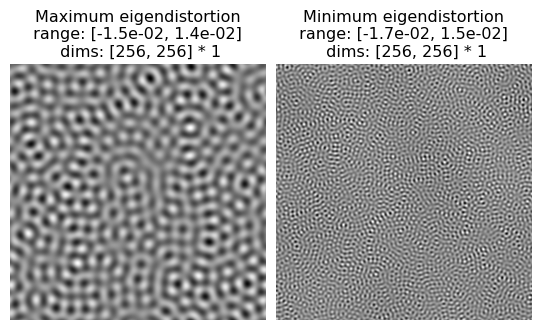

In [22]:
cs_eig = po.synthesize.Eigendistortion(img, center_surround)
cs_eig.synthesize();
po.imshow(cs_eig.eigendistortions, title=['Maximum eigendistortion', 
                                          'Minimum eigendistortion']);

In this case, we can see that the minimum eigendistortion looks similar to that of the `Gaussian`: an unoriented pattern of high-frequency noise. The maximum eigendistortion, however, has a much higher frequency than that of the `Gaussian`, corresponding to the change in the filter.

## Adding some nonlinear features to the mix

So far, our models have all been linear. That means that they're easy to understand, and we could indeed infer much of the information above by just looking at the Fourier transform of the model's filter[^fft]. However, if we add nonlinear features, analysis of model selectivity becomes trickier. To see what this looks like, let's use the `LuminanceGainControl` model, which adds gain control[^gaincontrol]: we take the output of the filter and divide it by the local luminance.

[^fft]: Try it yourself!
    ```python
    cs_filt = center_surround.filt
    gauss_filt = model.conv.weight.data
    filts = torch.cat([cs_filt, gauss_filt], dim=0)
    energy = torch.fft.fftshift(torch.fft.fft2(filts).abs())
    po.imshow(energy)
    ```
[^gaincontrol]: Gain control, or divisive normalization, is ubiquitous in the central nervous system and has been proposed as a [canonical neural computation](https://www.nature.com/articles/nrn3136) which allows the brain to maximize sensitivity to relevant stimuli in changing contexts.

<div class='render-strip'>
- The `LuminanceGainControl` model adds a nonlinearity, gain control. This makes the model harder to reason than the first two models.
- This model divides the output of the `CenterSurround` filter with an estimate of local luminance (the output of a larger Gaussian filter), which makes the model completely insensitive to absolute pixel values. It now cares about contrast, rather than luminance.
- This is a computation that we think is present throughout much of the early visual system.
</div>

In [23]:
lg = po.simulate.LuminanceGainControl((31, 31), pad_mode="circular").to(DEVICE)
params_dict = {'luminance_scalar': 14.95, 'luminance.std': 4.235, 
               'center_surround.center_std': 1.962, 'center_surround.surround_std': 4.235,
               'center_surround.amplitude_ratio': 1.25}
lg.load_state_dict({k: torch.as_tensor([v]) for k, v in params_dict.items()})
po.tools.remove_grad(lg)
lg.eval()

LuminanceGainControl(
  (center_surround): CenterSurround()
  (luminance): Gaussian()
)

This builds in additional invariances to the model, making it explicitly less sensitive to changes in the local luminance, so that if you double all the pixel values in the image, the model's response remains the same:

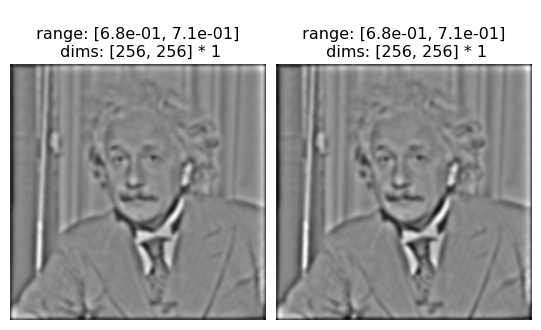

In [24]:
po.imshow([lg(img), lg(2*img)], vrange='auto1');

Now let's go ahead and synthesize and visualize metamers for this model. This will look the same as before, except we're going to explicitly initialize the optimizer object. This allows us to set the learning rate to a value slightly lower than the default, which allows us to find a better solution here.

In [25]:
lg_metamer = po.synthesize.Metamer(img.repeat(3, 1, 1, 1), lg)
lg_metamer.setup(initial_image=init_img, optimizer_kwargs={"lr": .007})
lg_metamer.synthesize(3500, stop_criterion=1e-11)

  0%|          | 0/3500 [00:00<?, ?it/s]

And let's visualize our results:

<div class='render-strip'>
- The model metamers here look fairly similar to those of the `CenterSurround` model, though you can see these are more "gray", because this model is even less sensitive to the local luminance than the previous model.
</div>

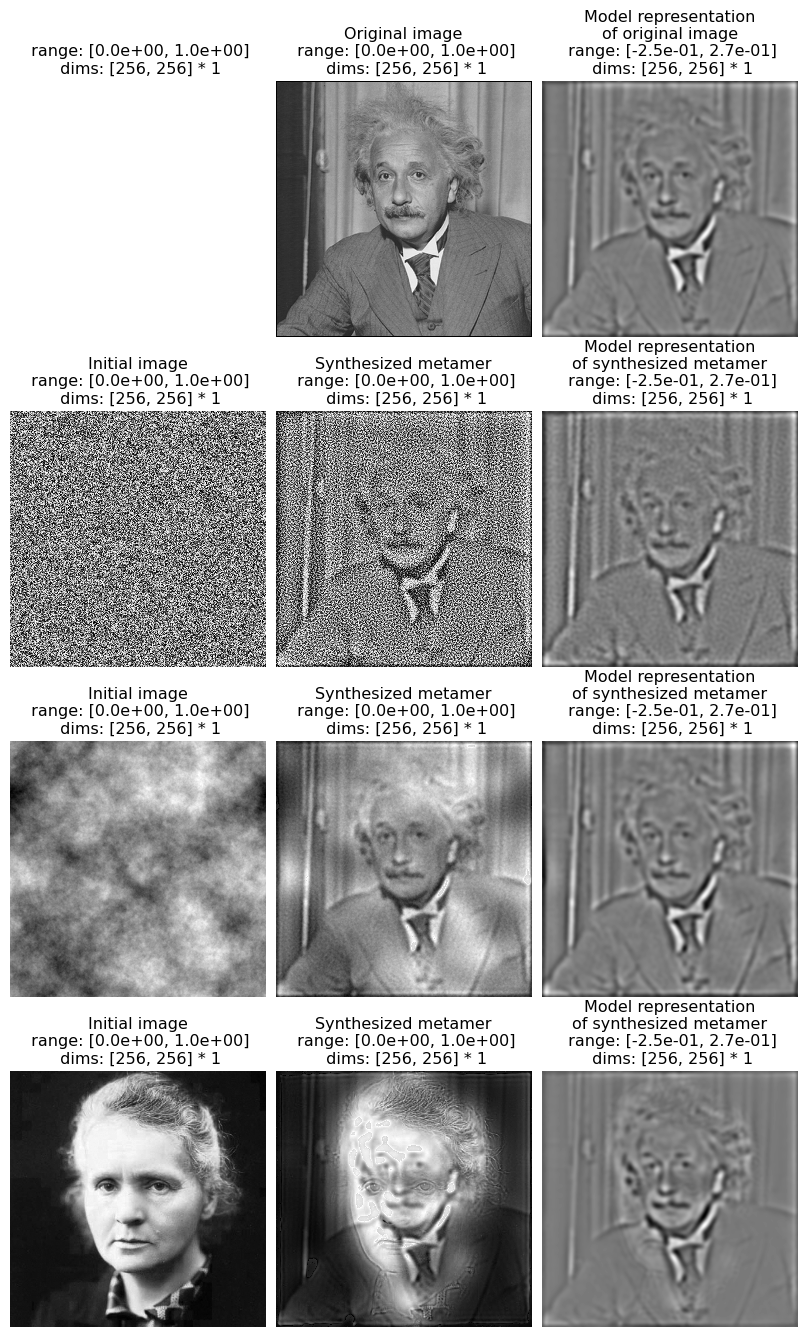

In [26]:
# this requires a little reorganization of the tensors:
to_plot = [torch.cat([torch.ones_like(img), img, center_surround(img)])]
for i, j in zip(init_img, lg_metamer.metamer):
    to_plot.append(torch.stack([i, j, center_surround(j)]))
to_plot = torch.cat(to_plot)
fig = po.imshow(to_plot, col_wrap=3, 
                title=['', 'Original image', 'Model representation\nof original image']+
                       3*['Initial image', 'Synthesized metamer', 'Model representation\nof synthesized metamer']);
# change the color scale of the images so that the first two columns go from 0 to 1 
# and the last one is consistent
for ax in fig.axes:
    if 'representation' in ax.get_title():
        clim = (to_plot[2::3].min(), to_plot[2::3].max())
    else:
        clim = (0, 1)
    ax.images[0].set_clim(*clim)
    title = ax.get_title().split('\n')
    title[-2] = f" range: [{clim[0]:.01e}, {clim[1]:.01e}]" 
    ax.set_title('\n'.join(title))

We can see that the `LuminanceGainControl` model metamers look somewhat similar to that of the `CenterSurround` model, but taking the insensitivity to pixel values to an extreme --- because of the division by the local luminance, the model is completely invariant to it, so that the mean pixel values match those of the initializing image, fairly drmaatically.

Finally, let's look at our eigendistortions:

Top k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Top k=1 eigendists computed | Stop criterion 1.00E-07 reached.


Bottom k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Bottom k=1 eigendists computed | Stop criterion 1.00E-07 reached.


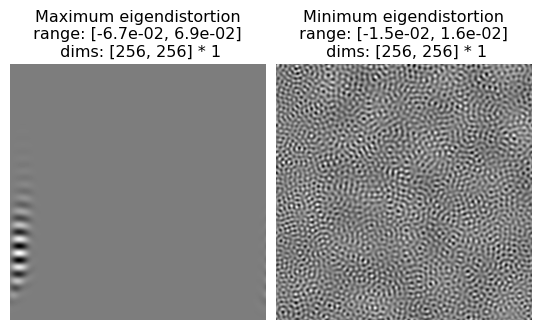

In [27]:
lg_eig = po.synthesize.Eigendistortion(img, lg)
lg_eig.synthesize();
po.imshow(lg_eig.eigendistortions, title=['Maximum eigendistortion', 
                                          'Minimum eigendistortion']);

:::{admonition} Question
:class: important

How do these eigendistortions compare to that of the `CenterSurround` model? Why do they, especially the maximum eigendistortion, look more distinct from those of the `CenterSurround` model than the metamers do?
:::

:::{admonition} Hint
:class: hint dropdown

The maximum eigendistortion emphasizes what the model is *most* sensitive to (whereas metamers focus on model invariances), so what about the `LinearGainControl` model's nonlinearities would cause this change?
:::

Again, the minimum eigendistortion looks fairly similar to before, but now our maximum eigendistortion looks quite different: it's a series of black and white stripes at defined location and orientation. This is a slightly subtle point: without gain control, the simple convolutional models we were investigating view changes everywhere in the image as equivalent and, therefore, a good strategy is to spread out the changes across the whole image. Now, however, gain control means that the model gives different outputs to the same frequency content depending on the local luminance; thus, it matters whether the distortion is placed in a dark or light portion of the image.

This adaptivity matters not just within images, but across images: the `CenterSurround` and `Gaussian` models' eigendistortions look the same on different images, whereas `LuminanceGainControl`'s eigendistortions vary depending on the image content:

<div class='render-strip'>
- Gain control makes this model adaptive, and thus the location of the eigendistortion matters, which was not true of our previous, linear models.
</div>

Top k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Top k=1 eigendists computed | Stop criterion 1.00E-07 reached.


Bottom k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Bottom k=1 eigendists computed | Stop criterion 1.00E-07 reached.


Top k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

Top k=1 eigendists computed | Stop criterion 1.00E-07 reached.


Bottom k=1 eigendists:   0%|          | 0/1000 [00:00<?, ?it/s]

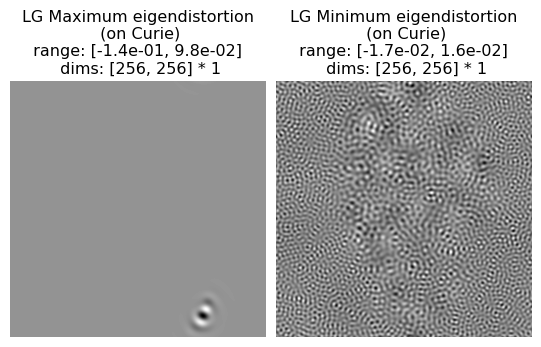

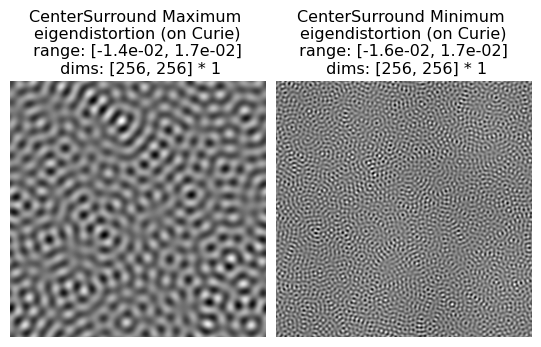

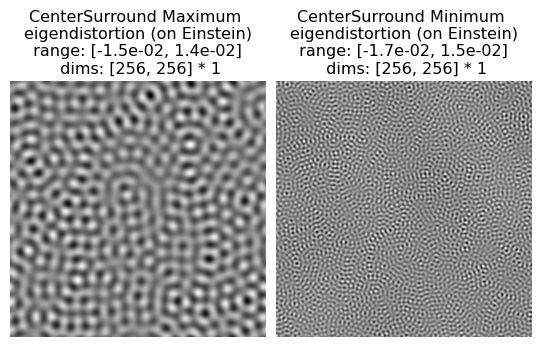

In [28]:
lg_curie_eig = po.synthesize.Eigendistortion(curie, lg)
lg_curie_eig.synthesize();
po.imshow(lg_curie_eig.eigendistortions, title=['LG Maximum eigendistortion\n (on Curie)', 
                                                'LG Minimum eigendistortion\n (on Curie)']);
cs_curie_eig = po.synthesize.Eigendistortion(curie, center_surround)
cs_curie_eig.synthesize();
po.imshow(cs_curie_eig.eigendistortions, title=['CenterSurround Maximum \neigendistortion (on Curie)', 
                                                'CenterSurround Minimum \neigendistortion (on Curie)']);
po.imshow(cs_eig.eigendistortions, title=['CenterSurround Maximum \neigendistortion (on Einstein)', 
                                          'CenterSurround Minimum \neigendistortion (on Einstein)']);

We've plotted the `CenterSurround` eigendistortions for comparison and we can see that, while they're not identical, they look essentially the same, regardless of the image: bandpass unoriented noisy patterns for the maximum distortion and the same pattern at a higher frequency for the minimum. The `LuminanceGainControl` eigendistortions, by comparison, vary based on the image. They are, however, consistent with each other: in both cases, the `LuminanceGainControl` maximum distortion is placed in a dark patch of the image, as can be seen more explicitly when we add them (we're multiplying the eigendistortions by 3 to make them more obvious):

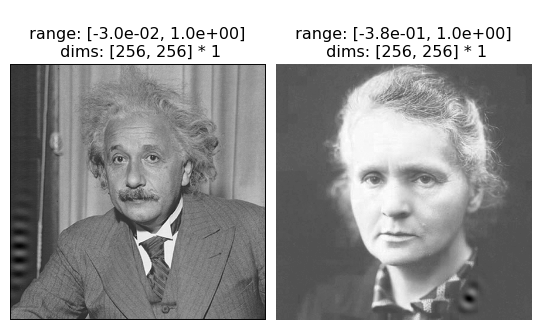

In [29]:
# the [:1] is a trick to get only the first element while still being a 4d
# tensor
po.imshow([img+3*lg_eig.eigendistortions[:1],
           curie+3*lg_curie_eig.eigendistortions[:1]]);

We can see that this exact placement matters by seeing what happens when we translate the eigendistortion on the Einstein image so it lies on his tie instead of in the dark part of the image:

Max LG eigendistortion: 0.08443846553564072
Shifted max LG eigendistortion: 0.03719748184084892


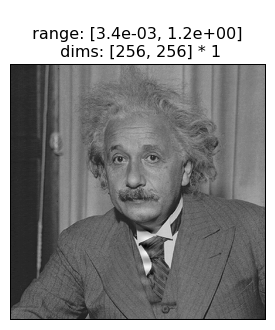

In [30]:
po.imshow(img+3*lg_eig.eigendistortions[:1].roll(128, -1))
print(f"Max LG eigendistortion: {po.tools.l2_norm(lg(img), lg(img+lg_eig.eigendistortions[:1]))}")
print(f"Shifted max LG eigendistortion: {po.tools.l2_norm(lg(img), lg(img+lg_eig.eigendistortions[:1].roll(128, -1)))}")

While translating the eigendistortion for the `CenterSurround` model has no effect:

In [31]:
print(f"Max CenterSurround eigendistortion: {po.tools.l2_norm(center_surround(img), center_surround(img+cs_eig.eigendistortions[:1]))}")
print(f"Shifted max CenterSurround eigendistortion: {po.tools.l2_norm(center_surround(img), center_surround(img+cs_eig.eigendistortions[:1].roll(128, -1)))}")

Max CenterSurround eigendistortion: 0.6445931196212769
Shifted max CenterSurround eigendistortion: 0.6445931792259216


We can thus see that the addition of gain control qualitatively changes the sensitivities of the model, making it less sensitive to the local luminance (as seen with the model metamers) but more sensitive to contrast, so that the placement of the distortions have a large effect on the size of their effect.

## Conclusion

<div class='render-both'>
<img src="_static/plan.svg">

In this notebook, we saw the basics of using `plenoptic` to investigate the sensitivities and invariances of some simple convolutional models, and reasoned through how the model metamers and eigendistortions we saw enable us to understand how these models process images.

`plenoptic` includes a variety of models and model components in the [plenoptic.simulate](https://plenoptic.readthedocs.io/en/latest/api/plenoptic.simulate.html) module, and you can (and should!) use the synthesis methods with your own models. Our documentation also has [examples](https://plenoptic.readthedocs.io/en/latest/tutorials/applications/Demo_Eigendistortion.html) showing how to use models from [torchvision](https://pytorch.org/vision/stable/index.html) (which contains a variety of pretrained neural network models) with plenoptic. In order to use your own models with plenoptic, check the [documentation](https://plenoptic.readthedocs.io/en/latest/models.html) for the specific requirements, and use the [`validate_model`](https://plenoptic.readthedocs.io/en/latest/api/plenoptic.tools.html#plenoptic.tools.validate.validate_model) function to check compatibility. If you have issues or want feedback, we're happy to help --- just post on the [Github discussions page](https://github.com/plenoptic-org/plenoptic/discussions)!

</div>